<a href="https://colab.research.google.com/github/jodejetalo99/Datos-Masivos/blob/master/Mini_Proyecto2_DM2_JJTL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Nacional Autónoma de México
# Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
# Datos Masivos II
# José de Jesús Tapia López
# Mini-proyecto2: Implementar el código del algoritmo FP-Tree
# 06 de Noviembre del 2020

## Objetivo 
Implementar el código del algoritmo FP-Tree en una libreta usando python.
Requisitos:
- La identificación de los elementos frecuentes deberá realizarse con al menos dos valores de soporte diferentes describiendo qué observaste y si se repitió algún conjunto de elementos.
- El código debe estar debidamente documentado y funcionando.
- Para la identificación de los elementos frecuentes deberás usar la siguiente base de datos: Groceries dataset

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cargamos los datos y mostramos los primeros 10 registros del csv
datos = pd.read_csv('drive/My Drive/Groceries_dataset.csv')
datos.head(10)

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
5,4941,14-02-2015,rolls/buns
6,4501,08-05-2015,other vegetables
7,3803,23-12-2015,pot plants
8,2762,20-03-2015,whole milk
9,4119,12-02-2015,tropical fruit


In [ ]:
# dimensiones de la bd
datos.shape

(38765, 3)

Por inspección, vemos que se compraron 38765 productos (incluyendo repetición).

In [ ]:
# ordenamos los datos conforme al member_number y a la fecha (date)
datos = datos.sort_values(['Member_number','Date'])
# mostramos los primeros 10 renglones de la bd ordenada
datos.head(10)

,Member_number,Date,itemDescription
4843,1000,15-03-2015,sausage
8395,1000,15-03-2015,whole milk
20992,1000,15-03-2015,semi-finished bread
24544,1000,15-03-2015,yogurt
13331,1000,24-06-2014,whole milk
29480,1000,24-06-2014,pastry
32851,1000,24-06-2014,salty snack
2047,1000,24-07-2015,canned beer
18196,1000,24-07-2015,misc. beverages
6388,1000,25-11-2015,sausage


In [ ]:
# Antes de continuar, obtemos los productos distintos que hay en la bd

elementos_unicos = np.unique(datos['itemDescription'])

# Número de elementos únicos

cant_elementos_unicos = len(elementos_unicos)


In [ ]:
# agrupamos los productos comprados en una misma transacción del mismo día, usando entonces el número (id) del cliente
# y la fecha de la transacción

datos_por_fecha = datos.groupby(['Member_number','Date'])['itemDescription'].apply(list).reset_index(name='itemDescription')
datos_por_fecha

,Member_number,Date,itemDescription
0,1000,15-03-2015,"[sausage, whole milk, semi-finished bread, yog..."
1,1000,24-06-2014,"[whole milk, pastry, salty snack]"
2,1000,24-07-2015,"[canned beer, misc. beverages]"
3,1000,25-11-2015,"[sausage, hygiene articles]"
4,1000,27-05-2015,"[soda, pickled vegetables]"
...,...,...,...
14958,4999,24-01-2015,"[tropical fruit, berries, other vegetables, yo..."
14959,4999,26-12-2015,"[bottled water, herbs]"
14960,5000,09-03-2014,"[fruit/vegetable juice, onions]"
14961,5000,10-02-2015,"[soda, root vegetables, semi-finished bread]"


In [ ]:
print("Número total de transacciones: ", len(datos_por_fecha))
print("Número de productos únicos: ", cant_elementos_unicos)


Número total de transacciones:  14963
Número de productos únicos:  167


Ahora sí vemos que realmente hay 14963 transacciones y 167 productos únicos.

In [ ]:
# Nos quedamos con solo la columna itemDescription, la cual tiene el nombre de los productos comprados

datos_por_fecha = datos_por_fecha.drop(datos_por_fecha.columns[[0, 1]], axis=1)
datos_por_fecha.head()

,itemDescription
0,"[sausage, whole milk, semi-finished bread, yog..."
1,"[whole milk, pastry, salty snack]"
2,"[canned beer, misc. beverages]"
3,"[sausage, hygiene articles]"
4,"[soda, pickled vegetables]"


## FP-Tree

### Paso 1: Escanear la base de datos y calcular la frecuencia de cada elemento. 


In [ ]:
# obtenemos un 'diccionario' 
# en counter le pasamos una lista, en dicha lista vamos almacenando los elementos, si hay
# elementos repetidos los va contando (en el diccionario, la 'llave' es el nombre del producto 
# y su 'valor' es la frecuencia de dicho producto)
frecuencia_elementos = Counter([e for t in datos_por_fecha['itemDescription'] for e in t])

# sumamos la frecuencia de cada producto para verificar que coincida con el número de 
# renglones de la base de datos inicial (un solo producto en cada renglón)

total_productos = sum(frecuencia_elementos.values())
total_productos

38765

### Paso 2: Ordenar por frecuencia descendentemente a los elementos y que cumplan con un minSup.

In [ ]:
# ordenamos descendentemente el Counter anterior

frecuencia_elementos_ord_desc = frecuencia_elementos.most_common()
# Vemos que ahora es una lista de Tuplas (solo es para visualizar)

frecuencia_elementos_ord_desc

[('whole milk', 2502),
 ('other vegetables', 1898),
 ('rolls/buns', 1716),
 ('soda', 1514),
 ('yogurt', 1334),
 ('root vegetables', 1071),
 ('tropical fruit', 1032),
 ('bottled water', 933),
 ('sausage', 924),
 ('citrus fruit', 812),
 ('pastry', 785),
 ('pip fruit', 744),
 ('shopping bags', 731),
 ('canned beer', 717),
 ('bottled beer', 687),
 ('whipped/sour cream', 662),
 ('newspapers', 596),
 ('frankfurter', 580),
 ('brown bread', 571),
 ('domestic eggs', 566),
 ('pork', 566),
 ('butter', 534),
 ('fruit/vegetable juice', 518),
 ('beef', 516),
 ('curd', 514),
 ('margarine', 491),
 ('coffee', 476),
 ('frozen vegetables', 425),
 ('chicken', 422),
 ('white bread', 362),
 ('cream cheese ', 358),
 ('chocolate', 357),
 ('dessert', 356),
 ('napkins', 335),
 ('hamburger meat', 327),
 ('berries', 327),
 ('UHT-milk', 323),
 ('onions', 305),
 ('salty snack', 283),
 ('waffles', 280),
 ('long life bakery product', 269),
 ('sugar', 265),
 ('butter milk', 263),
 ('ham', 256),
 ('meat', 254),
 ('froz

In [ ]:
j = 0
for i in frecuencia_elementos_ord_desc:
  j += i[1]
j

38765

In [ ]:
# indicamos el minSup
minSup = 0.1136
# nos quedamos con aquellos que cumplan con que sean mayores o iguales al minSup
frecuencia_elementos_minSup = [c[0] for c in frecuencia_elementos.items() if c[1]/len(datos_por_fecha) >= minSup]
# nos quedamos con la tupla (producto, frecuencia) de aquellos que cumplan con el minSup
frecuencia_elementos_minSup_tup = [(c[0],c[1]) for c in frecuencia_elementos.items() if c[1]/len(datos_por_fecha) >= minSup]
# ordenamos la lista de dichas tuplas descendentemente
frecuencia_elementos_minSup_tup = sorted(frecuencia_elementos_minSup_tup, key=lambda x: x[1],reverse=True)
frecuencia_elementos_minSup_tup

[('whole milk', 2502), ('other vegetables', 1898), ('rolls/buns', 1716)]

In [ ]:
print("Total de transacciones con esos elementos: ", np.sum([c[1] for c in frecuencia_elementos_minSup_tup]))

Total de transacciones con esos elementos:  6116


In [ ]:
print("Número de productos que son mayores o iguales al soporte mínimo de {}: ".format(minSup), len(frecuencia_elementos_minSup))

Número de productos que son mayores o iguales al soporte mínimo de 0.1136:  3


### Paso 3: por cada transacción, escribimos los elementos frecuentes que cumplen con el minSup y los ordenamos de forma descendente.


In [ ]:
# de la lista de tuplas (que contiene a los productos y su frecuencia de aquellos
# que cumplen con ser mayores o iguales al minSup), nos quedamos solo con la primera
# entrada de cada una, es decir, con el nombre del producto
elementos_minSup_ord = [i[0] for i in frecuencia_elementos_minSup_tup]

# creamos una lista vacía en la cual vamos a ir guardando en listas
# los elementos frecuentes de cada transacción
elementos_minSup_frecuentes = []

# vamos a iterar por cada transacción de la bd: de la lista que contiene
# a los productos que cumplen con el minSup, vamos a revisar uno por uno
# si es que se encuentran en cada transaccion; van a estar ordenados 
# descendentemente ya que la lista elementos_minSup_ord extrajo los productos
# en dicho orden
for i in range(len(datos_por_fecha['itemDescription'])):
  # esta lista es auxiliar, y la vamos a crear en cada transacción de la bd
  # para guardar en dicha forma a los elementos (ordenados descendentemente)
  # que sí sean frecuentes de la transacción corrrespondiente
  elementos_minSup_frecuentes_trans = []
  for j in range(len(elementos_minSup_ord)):
    if elementos_minSup_ord[j] in datos_por_fecha['itemDescription'][i]: 
        elementos_minSup_frecuentes_trans.append(elementos_minSup_ord[j])
  # entonces esta es una lista de listas, en la que cada una de dichas
  # listas tiene a los elementos frecuentes de cada transacción
  elementos_minSup_frecuentes.append(elementos_minSup_frecuentes_trans)

len(elementos_minSup_frecuentes)

14963

In [ ]:
# Creamos una nueva columna para seleccionar los items que cumplen con ser mayores o iguales
# al minSup, es decir, creamos la columna "itemDescriptionFreq" con los elementos (que son listas) 
# de la lista  que acabamos de crear en las dos iteraciones pasadas
datos_por_fecha['itemDescriptionFreq'] = elementos_minSup_frecuentes
datos_por_fecha.head(10)

,itemDescription,itemDescriptionFreq
0,"[sausage, whole milk, semi-finished bread, yog...",[whole milk]
1,"[whole milk, pastry, salty snack]",[whole milk]
2,"[canned beer, misc. beverages]",[]
3,"[sausage, hygiene articles]",[]
4,"[soda, pickled vegetables]",[]
5,"[frankfurter, curd]",[]
6,"[sausage, whole milk, rolls/buns]","[whole milk, rolls/buns]"
7,"[whole milk, soda]",[whole milk]
8,"[beef, white bread]",[]
9,"[frankfurter, soda, whipped/sour cream]",[]


In [ ]:
#datos_por_fecha.to_csv('drive/My Drive/dm.txt')

### Paso 4: por cada transacción se construye una rama en el FP-tree. 

- Si existe una ruta con prefijo común: Incrementar la frecuencia de los nodos en esta ruta y agregar el sufijo
- En caso contrario crear una nueva rama.

In [ ]:
# creamos la columna itemDescriptionFreqString para convertir las listas que contienen los elementos frecuentes de cada transaccion a un string
datos_por_fecha['itemDescriptionFreqString'] = [', '.join(map(str, l)) for l in datos_por_fecha['itemDescriptionFreq']]
datos_por_fecha.head(10)

,itemDescription,itemDescriptionFreq,itemDescriptionFreqString
0,"[sausage, whole milk, semi-finished bread, yog...",[whole milk],whole milk
1,"[whole milk, pastry, salty snack]",[whole milk],whole milk
2,"[canned beer, misc. beverages]",[],
3,"[sausage, hygiene articles]",[],
4,"[soda, pickled vegetables]",[],
5,"[frankfurter, curd]",[],
6,"[sausage, whole milk, rolls/buns]","[whole milk, rolls/buns]","whole milk, rolls/buns"
7,"[whole milk, soda]",[whole milk],whole milk
8,"[beef, white bread]",[],
9,"[frankfurter, soda, whipped/sour cream]",[],


In [ ]:
# obtenemos el arbol con el orden descendente en sus ramas 

# agrupamos con la  columna que acabamos de crear, itemDescriptionFreqString, para ver la frecuencia de cada rama
# usamos el método size para contar el número de renglones de cada grupo 
arbol = datos_por_fecha.groupby(['itemDescriptionFreqString']).size().reset_index(name = 'frecuencia')
arbol

,itemDescriptionFreqString,frecuencia
0,,9698
1,other vegetables,1465
2,"other vegetables, rolls/buns",140
3,rolls/buns,1297
4,whole milk,1950
5,"whole milk, other vegetables",204
6,"whole milk, other vegetables, rolls/buns",18
7,"whole milk, rolls/buns",191


Vemos que hay 9698 transacciones en las que no hay ninguno de los elementos que cumplen con ser mayores o iguales al minSup; por lo que vamos a eliminar ese renglón.



In [ ]:
arbol = arbol.iloc[1:]
arbol

,itemDescriptionFreqString,frecuencia
1,other vegetables,1465
2,"other vegetables, rolls/buns",140
3,rolls/buns,1297
4,whole milk,1950
5,"whole milk, other vegetables",204
6,"whole milk, other vegetables, rolls/buns",18
7,"whole milk, rolls/buns",191


In [ ]:
# vamos a obtener el primer elemento de cada lista y contar su frecuencia
un_elemento_frec = Counter(datos_por_fecha['itemDescriptionFreq'].str[0].dropna())
un_elemento_frec


Counter({'other vegetables': 1605, 'rolls/buns': 1297, 'whole milk': 2363})

In [ ]:
# Creamos un grafo dirigido con networkx para visualizar el árbol

# Generamos el grafo dirigido D
G = nx.DiGraph()

# Insertamos el nodo vacío
G.add_node("{}")

for nodo in un_elemento_frec.keys():
    # nos quedamos con las primera letra de cada producto
    palabra_abrev = [s[0] for s in nodo.split()]
    palabra_abrev = " ".join(palabra_abrev)
    #print(palabra_abrev)
    # Agregamos los nodos del árbol en el primer nivel con su respectiva frecuencia
    G.add_node(palabra_abrev+":"+str(un_elemento_frec.get(nodo)))
    #print(nodo)
    # Creamos los aristas que van desde el nodo vacío a estos nodos del primer nivel
    G.add_edges_from([("{}", palabra_abrev+":"+str(un_elemento_frec.get(nodo)))])
    #print("{}", palabra_abrev+":"+str(un_elemento_frec.get(nodo)))


In [ ]:
# vamos a crear las ramas de cada rama, es decir, vamos a insertar los nodos del segundo nivel
# del árbol con su correspondiente nodo antecedente

# obtenemos las listas que tengan hasta dos elementos y contamos su frecuencia

# hacemos el map a una tupla ya que las listas son unhashables
dos_elementos_frec = Counter(map(tuple, datos_por_fecha['itemDescriptionFreq'].str[0:2]))

# este diccionario contendrá solo las llaves que sean de longitud 2
dos_elementos_frec_dict = {}

# iteramos con los elementos del counter para quedarnos con los que tengan en su llave una longitud
# de dos
for k in dos_elementos_frec.keys():
  if len(k) == 2:
    dos_elementos_frec_dict[k] = dos_elementos_frec[k]

dos_elementos_frec_dict


{('other vegetables', 'rolls/buns'): 140,
 ('whole milk', 'other vegetables'): 222,
 ('whole milk', 'rolls/buns'): 191}

En la celda anterior realmente solo nos va a interesar el segundo valor de la tupla de cada llave del diccionario, pero nos quedamos con el primer valor para saber a qué rama corresponde

In [ ]:
# añadimos los nodos y sus aristas del segundo nivel
# notamos que tenemos varios 'indices' para un mismo producto, ya
# que están en un distinto nivel (profundidad) en el árbol,

G.add_node("r 2:140")
G.add_node("o v:222")
G.add_node("r 3:191")
G.add_edges_from([("o v:1605","r 2:140"),("w m:2363","o v:222"),("w m:2363","r 3:191")])

In [ ]:

# hacemos lo mismo que en el caso del segundo nivel pero ahora para el tercer nivel del árbol 

tres_elementos_frec = Counter(map(tuple, datos_por_fecha['itemDescriptionFreq'].str[0:3]))
tres_elementos_frec_dict = {}

for k in tres_elementos_frec.keys():
  if len(k) == 3:
    tres_elementos_frec_dict[k] = tres_elementos_frec[k]

tres_elementos_frec_dict

{('whole milk', 'other vegetables', 'rolls/buns'): 18}

In [ ]:
G.add_node("r 4:18")
G.add_edges_from([("o v:222","r 4:18")])

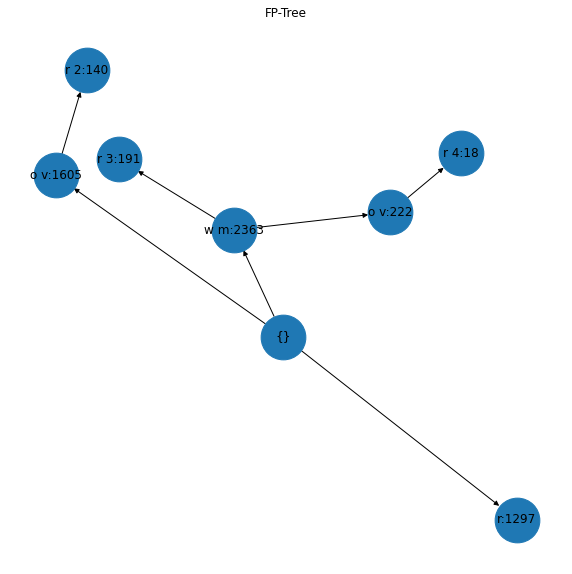

In [ ]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.title('FP-Tree')
#pos=graphviz_layout(G, prog='dot')
nx.draw(G, with_labels=True, node_size=2000)

Vamos a hacer lo mismo que en las celdas anteriores, pero ahora con un minSup distinto al anterior

In [ ]:
minSup2 = 0.1
frecuencia_elementos_minSup2 = [c[0] for c in frecuencia_elementos.items() if c[1]/len(datos_por_fecha) >= minSup2]
frecuencia_elementos_minSup2_tup = [(c[0],c[1]) for c in frecuencia_elementos.items() if c[1]/len(datos_por_fecha) >= minSup2]
frecuencia_elementos_minSup2_tup = sorted(frecuencia_elementos_minSup2_tup, key=lambda x: x[1],reverse=True)
print("Elementos que son mayores o iguales al minSup2:", frecuencia_elementos_minSup2_tup)
print("Número de productos que son mayores o iguales al soporte mínimo de {}: ".format(minSup2), len(frecuencia_elementos_minSup2))
print("Total de transacciones que con esos elementos: ", np.sum([c[1] for c in frecuencia_elementos_minSup2_tup]))

elementos_minSup2_ord = [i[0] for i in frecuencia_elementos_minSup2_tup]

elementos_minSup2_frecuentes = []

for i in range(len(datos_por_fecha['itemDescription'])):
  # esta lista es auxiliar, y la vamos a crear en cada transacción de la bd
  # para guardar en dicha forma a los elementos (ordenados descendentemente)
  # que sí sean frecuentes de la transacción corrrespondiente
  elementos_minSup2_frecuentes_trans = []
  for j in range(len(elementos_minSup2_ord)):
    if elementos_minSup2_ord[j] in datos_por_fecha['itemDescription'][i]: 
        elementos_minSup2_frecuentes_trans.append(elementos_minSup2_ord[j])
  # entonces esta es una lista de listas, en la que cada una de dichas
  # listas tiene a los elementos frecuentes de cada transacción
  elementos_minSup2_frecuentes.append(elementos_minSup2_frecuentes_trans)

datos_por_fecha['itemDescriptionFreq2'] = elementos_minSup2_frecuentes
datos_por_fecha['itemDescriptionFreqString2'] = [', '.join(map(str, l)) for l in datos_por_fecha['itemDescriptionFreq2']]
datos_por_fecha.head(10)

Elementos que son mayores o iguales al minSup2: [('whole milk', 2502), ('other vegetables', 1898), ('rolls/buns', 1716), ('soda', 1514)]
Número de productos que son mayores o iguales al soporte mínimo de 0.1:  4
Total de transacciones que con esos elementos:  7630


,itemDescription,itemDescriptionFreq,itemDescriptionFreqString,itemDescriptionFreq2,itemDescriptionFreqString2
0,"[sausage, whole milk, semi-finished bread, yog...",[whole milk],whole milk,[whole milk],whole milk
1,"[whole milk, pastry, salty snack]",[whole milk],whole milk,[whole milk],whole milk
2,"[canned beer, misc. beverages]",[],,[],
3,"[sausage, hygiene articles]",[],,[],
4,"[soda, pickled vegetables]",[],,[soda],soda
5,"[frankfurter, curd]",[],,[],
6,"[sausage, whole milk, rolls/buns]","[whole milk, rolls/buns]","whole milk, rolls/buns","[whole milk, rolls/buns]","whole milk, rolls/buns"
7,"[whole milk, soda]",[whole milk],whole milk,"[whole milk, soda]","whole milk, soda"
8,"[beef, white bread]",[],,[],
9,"[frankfurter, soda, whipped/sour cream]",[],,[soda],soda


In [ ]:
arbol = datos_por_fecha.groupby(['itemDescriptionFreqString2']).size().reset_index(name = 'frecuencia')
arbol = arbol.iloc[1:]
arbol

,itemDescriptionFreqString2,frecuencia
1,other vegetables,1353
2,"other vegetables, rolls/buns",124
3,"other vegetables, rolls/buns, soda",16
4,"other vegetables, soda",112
5,rolls/buns,1207
6,"rolls/buns, soda",90
7,soda,1061
8,whole milk,1807
9,"whole milk, other vegetables",188
10,"whole milk, other vegetables, rolls/buns",17


In [ ]:

# la siguiente función calcula las listas que tengan hasta n elementos, de la columna con el minSup2, y contamos su frecuencia
def elementosFrec(n):

  n_elementos_frec = Counter(map(tuple, datos_por_fecha['itemDescriptionFreq2'].str[0:n]))
  n_elementos_frec_dict = {}

  # de dos
  for k in n_elementos_frec.keys():
    if len(k) == n:
      n_elementos_frec_dict[k] = n_elementos_frec[k]

  return n_elementos_frec_dict

In [ ]:
un_elemento_frec1 = Counter(datos_por_fecha['itemDescriptionFreq2'].str[0].dropna())
un_elemento_frec1

Counter({'other vegetables': 1605,
         'rolls/buns': 1297,
         'soda': 1061,
         'whole milk': 2363})

In [ ]:
dos_elementos_frec_dict2 = elementosFrec(2)
dos_elementos_frec_dict2

{('other vegetables', 'rolls/buns'): 140,
 ('other vegetables', 'soda'): 112,
 ('rolls/buns', 'soda'): 90,
 ('whole milk', 'other vegetables'): 222,
 ('whole milk', 'rolls/buns'): 191,
 ('whole milk', 'soda'): 143}

In [ ]:
tres_elementos_frec_dict2 = elementosFrec(3)
tres_elementos_frec_dict2

{('other vegetables', 'rolls/buns', 'soda'): 16,
 ('whole milk', 'other vegetables', 'rolls/buns'): 18,
 ('whole milk', 'other vegetables', 'soda'): 16,
 ('whole milk', 'rolls/buns', 'soda'): 14}

In [ ]:
cuatro_elementos_frec_dict2 = elementosFrec(4)
cuatro_elementos_frec_dict2

{('whole milk', 'other vegetables', 'rolls/buns', 'soda'): 1}

NOTA: Ya no dibujo el grafo porque quedaba muy amontonado y no había una buena visualización

## Conclusiones

Podemos observar que realmente los conjuntos de elementos en los árboles de cada minSup son distintos. Sin embargo, lo que pasa es que en el segundo árbol se le agregan nodos a las ramas del primer árbol, incluyendo una nueva rama: soda. Por lo tanto, la profundidad del segundo árbol es de 4  (sin incluir al nodo vacío).

Podemos observar que en el primer árbol tenemos $2^3 - 1$ nodos (sin incluir al nodo vacío, es decir,a la raíz); mientras que en el segundo árbol tendríamos  $2^4 - 1$ nodos (sin incluir al nodo vacío, es decir,a la raíz). El exponente está relacionado con el número de elementos que son mayores o iguales al minSup en cada caso; sin embargo, eso no bastaría para generalizar la relación de que hay un total de $2^n-1$ nodos, donde $n$ sería el número de elementos que son mayores o iguales al minSup; pues puede darse el caso en que no tengamos en el arbol el conjunto potencia de dichos $n$ elementos.